# Exercise4 Report - head-pose

## lesson
* lession 3 Multi-label classification, Segmentation

## student
* 20161622 이예은

## Regression with BIWI head pose dataset


**Regression** consists of a set of machine learning methods that allow us to predict a continuous outcome variable (y) based on the value of one or multiple predictor variables (x).
 
[BIWI head pose dataset](https://data.vision.ee.ethz.ch/cvl/gfanelli/head_pose/head_forest.html#db) is example of regression. This purpose is to find the center of the head and predict the coordinates of items on pictures.

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# Any edits to libraries you make are reloaded here automatically and any charts or images displayed are shown in this notebook.

In [0]:
from fastai.vision import *
#import neccesary library

## Getting and converting the data

In [3]:
path = untar_data(URLs.BIWI_HEAD_POSE)
# untar BIWI_HEAD_POSE data

In [4]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

# read rgb.cal
# data for translate coordinate

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [0]:
fname = '09/frame_00667_rgb.jpg'
# set file name

In [0]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

#define function to get coordinate(result of data) file mapping f(image file name)

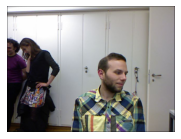

In [7]:
img = open_image(path/fname)
img.show()
# show images by fname

In [8]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr
# show coordinate

array([187.332 ,  40.3892, 893.135 ])

In [0]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

# define functions for converting coordinate and show point by the coordiate

In [10]:
get_ctr(fname)
# convert coordinate 

tensor([263.9104, 428.5814])

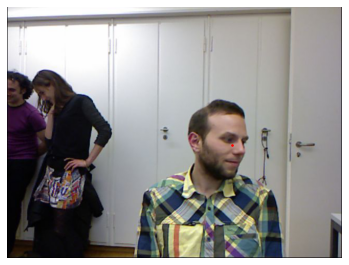

In [11]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6))
# convert coordinate and show data and point

## Creating a dataset

In [0]:
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )
# create datasetbunch
# labeled from get_ctr function (it defined above)
# transform result data too

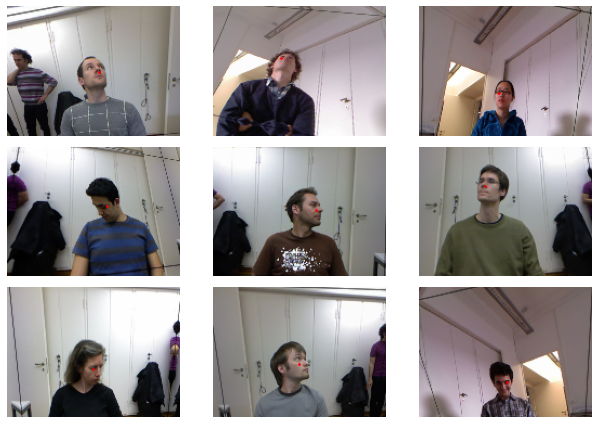

In [13]:
data.show_batch(3, figsize=(9,6))
# show a batch of data( images and pointing center of head)

## Train model

In [14]:
learn = cnn_learner(data, models.resnet34)
# set cnn learner using resnet34 models

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


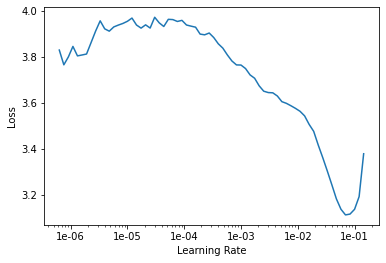

In [15]:
learn.lr_find()
learn.recorder.plot()
# find learning rate and show a graph

In [0]:
lr = 2e-2
# set learning rate

In [17]:
learn.fit_one_cycle(5, slice(lr))
# train 5 cycles

epoch,train_loss,valid_loss,time
0,0.125355,0.017504,02:54
1,0.042889,0.003535,03:03
2,0.015288,0.004363,03:02
3,0.008447,0.001386,02:57
4,0.006515,0.001670,02:55


In [0]:
learn.save('stage-1')
# save the model

In [0]:
learn.load('stage-1');
# load the model

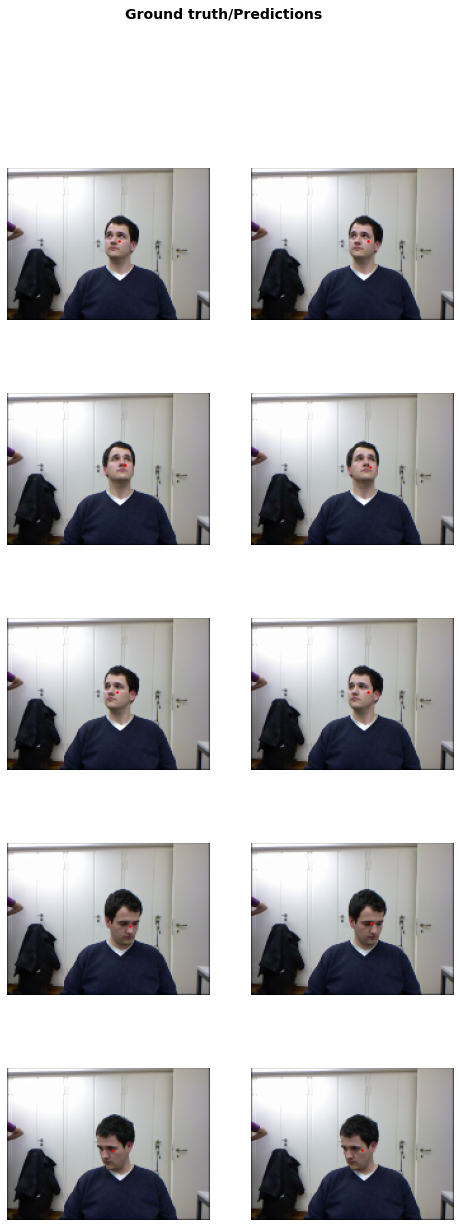

In [20]:
learn.show_results()
# show result of the model (truth & predictions)

## Data augmentation

Customizing argumentation of models

In [0]:
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(tfms, tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )
# set transform and create normalized databunch

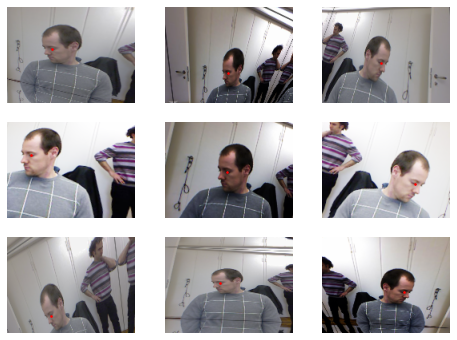

In [22]:
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,6))
# define function to define plotting datas
# and plot multiple data